## CCF: 企业非法集资风险预测

In [2]:
import time
import math
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from util import *

t_base_info = "./dataset/train/base_info.csv"
t_annual_report_info = "./dataset/train/annual_report_info.csv"
t_tax_info = "./dataset/train/tax_info.csv"
t_change_info = "./dataset/train/change_info.csv"
t_news_info = "./dataset/train/news_info.csv"
t_other_info = "./dataset/train/other_info.csv"
t_entprise_info = "./dataset/train/entprise_info.csv" # train labeled data

In [3]:
# print("Reading...")
# base_info = pd.read_csv('dataset/train/base_info.csv')
# base_info.info()

### entprise_info

In [4]:
df_label_info = pd.read_csv(t_entprise_info, header=0)

print(df_label_info.info())
print(df_label_info.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14865 entries, 0 to 14864
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      14865 non-null  object
 1   label   14865 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 232.4+ KB
None
(14865, 2)


标签类别数  [1 0]
训练企业数量  14865
0    13884
1      981
Name: label, dtype: int64
8f19388cfd6e2b9cf0514566e39fefeebab9a32f7ba7bb85    1
8f19388cfd6e2b9c5fa6bdd58b634184d76c01f2d4d8d2d2    1
d8071a739aa75a3b56565f5510af4ee6274971a92bd9151f    1
59b38c56de3836834a590a0d08175f6ed4eb8bbcafbe692d    1
beb4aaaa89e0a0aef16d63c5aa3aefc959dc25c2096d0637    1
                                                   ..
d8071a739aa75a3b0d0baef68ccca70c2c94f1ad9a1ed7a0    1
47645761dc56bb8c9c77bc249441a8cb5f1a176f2d596a5d    1
216bd2aaf4d07924d3d6fc122a30ee47b608f782a8f4791b    1
59b38c56de383683004280ff43e105e5d55f112855cad5bf    1
f000950527a6feb6eefd07cc621c088f02afa948ed7fc197    1
Name: id, Length: 14865, dtype: int64


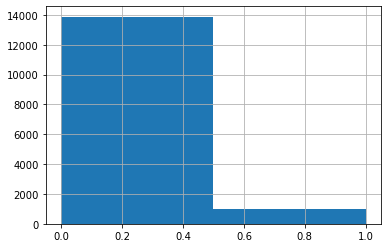

In [5]:
print("标签类别数 ", df_label_info['label'].unique())
print("训练企业数量 ", len(df_label_info['id'].unique()))
print(df_label_info['label'].value_counts())
print(df_label_info['id'].value_counts())

df_label_info['label'].hist(bins=2)

### other_info.csv

In [6]:
# TODO: 特征空值过多 如何处理？ #
df_other_info = pd.read_csv(t_other_info, header=0)
print(df_other_info['legal_judgment_num'].value_counts()) # 裁判文书数量, 法律纠纷数量
print(df_other_info['brand_num'].value_counts())          # 注册商标数量
print(df_other_info['patent_num'].value_counts())         # 专利数量
print(df_other_info.shape)                                
print(df_other_info.head(5))                              


1.0      282
2.0      175
3.0       93
4.0       66
5.0       55
        ... 
37.0       1
128.0      1
76.0       1
80.0       1
90.0       1
Name: legal_judgment_num, Length: 93, dtype: int64
1.0      311
2.0      180
3.0       85
4.0       58
5.0       36
        ... 
38.0       1
199.0      1
200.0      1
361.0      1
421.0      1
Name: brand_num, Length: 82, dtype: int64
2.0      40
1.0      29
3.0      23
6.0      15
4.0      14
         ..
200.0     1
353.0     1
153.0     1
273.0     1
52.0      1
Name: patent_num, Length: 114, dtype: int64
(1890, 4)
                                                 id  legal_judgment_num  \
0  f000950527a6feb6d340f91da09e61347d8200cd2f0d1602                 4.0   
1  f000950527a6feb608dd9322b74a99f60851207f36a3c94c                 1.0   
2  d8071a739aa75a3b9f23966f8dae78fd226c272515b9c255                 2.0   
3  216bd2aaf4d079242209b1496f81a36c7abed9dd0bb65ed3                 NaN   
4  e9f7b28ec10e0470de9631c789f49acdd4e7cf9ed6db094b         

In [7]:
# 统计空值的个数
null_cnt_lj = df_other_info['legal_judgment_num'].isnull().sum(axis=0)
null_cnt_br = df_other_info['brand_num'].isnull().sum(axis=0)
null_cnt_pt = df_other_info['patent_num'].isnull().sum(axis=0)
print(null_cnt_lj, null_cnt_br, null_cnt_pt)



884 981 1494


In [8]:
training_set = pd.merge(df_label_info, df_other_info, how='left', on='id')
# 释放内存
# del df_label_info
# del df_other_info
# training_set[training_set['id'] == "f000950527a6feb63702b1f6c1dabe5ea196d320bbbff425"]
print(len(training_set['id'].value_counts()))
training_set = training_set.groupby(['id'], as_index=False).mean()
print(training_set.shape)

14865
(14865, 5)


### news_info.csv

In [9]:
#  TODO: 随着时间变化，news的态度不同 但是标签只能是一个#
df_news_info = pd.read_csv(t_news_info, header=0)
print(df_news_info['id'].value_counts())
print(df_news_info.shape)
print(len(df_news_info['id'].unique()))

dict_atitude = {"积极": 1, "中立": 0.1, "消极": -1}
df_news_info['positive_negtive'] = df_news_info['positive_negtive'].map(lambda x : dict_atitude[x])
# public date 转变成迄今为止发生时间
cmp_date = "2020-10-09"
from util import *

# df_news_info['public_date'] = df_news_info['public_date'].map(lambda x: check_date(x))
# df_news_info['public_date'].value_counts()
# 处理"xx小时前" 数据统一为昨天更新 
def handle_public_date(str):
    if(check_date(str) == False):
        return 1
    else:
        return days(cmp_date, str)
df_news_info['public_date'] = df_news_info['public_date'].map(lambda x: handle_public_date(x))

print(df_news_info.shape)

# 新闻发布时间，越久远 因子越小
print(df_news_info.head())
print(df_news_info['public_date'].max())
df_news_info['news_factor'] = 1 - (df_news_info['public_date'] / df_news_info['public_date'].max())
df_news_info['news_factor'] = df_news_info[['news_factor', 'positive_negtive']].apply(lambda x: x['news_factor'] * x['positive_negtive'], axis=1)

del df_news_info['positive_negtive']
del df_news_info['public_date']
df_news_info = df_news_info.groupby(['id'], as_index=False).sum()

print(df_news_info.head())
print(df_news_info.shape)
print(df_news_info['news_factor'].value_counts())
print(df_news_info['news_factor'].max())



f000950527a6feb63702b1f6c1dabe5ea196d320bbbff425    1193
f000950527a6feb6b1cedd99a67ea0c20a3ce2ca11761489     780
d8071a739aa75a3b04c9a1789bd657ef83e10c02b1a9fef5     290
f000950527a6feb6c296eca7091876ac6cba7097c9c7d2ee     272
f000950527a6feb6194eb25023f715fa9ec0166d20cc8aed     215
                                                    ... 
f000950527a6feb693802ae97616054c3e5b5755fc8e47b7       1
f000950527a6feb66105bfbb5f80ae92bc45322a9f94a130       1
f000950527a6feb6a805d13d51322b8bffa525cfab59b75e       1
f000950527a6feb6bc68e84ab24d8af646bcb30f2e97e1c8       1
f000950527a6feb6901a756b3bb5977229b185ad31710215       1
Name: id, Length: 927, dtype: int64
(10518, 3)
927
(10518, 3)
                                                 id  positive_negtive  \
0  f000950527a6feb62669d6a175fe6fdccd1eb4f7ca8e5016               1.0   
1  f000950527a6feb6e8bd9919e2ca363359bcfa997a0f9de7               0.1   
2  f000950527a6feb6e8bd9919e2ca363359bcfa997a0f9de7              -1.0   
3  d8071a739aa75a3b

In [10]:
training_set = pd.merge(training_set, df_news_info, how='left', on='id')
# print(training_set.head())
# print(training_set['positive_negtive'].value_counts())
print(training_set.shape)
print(training_set.tail(10))
# print(training_set['positive_negtive'].value_counts())


(14865, 6)
                                                     id  label  \
14855  f1c1045b13d18329feb49317c30665c7de5a66d4024c205f      0   
14856  f1c1045b13d18329ff12a0666b8a400b902fda7815ed4d05      0   
14857  f1c1045b13d18329ff3fc0c5b0bb11919c9e966a0b0c0781      0   
14858  f1c1045b13d18329ff62260c744223b68f1c22d9687d4569      0   
14859  f1c1045b13d18329ff712679aeb2de2622ebd54670ae90d3      0   
14860  f6eb47aa168d4141ebdc3e35a7b37a3cb15baa8608f730a0      0   
14861  ff2c78b9022767a53da2e5a811e4aa9583e32efc9899f9f3      0   
14862  ff2c78b9022767a56f3cbb4688ebd94b062278c25f8ae074      0   
14863  ff2c78b9022767a5eaca0af7685725abefc80e4f9106c285      0   
14864  ff2c78b9022767a5ebe009942841f102147e68e19c705f89      0   

       legal_judgment_num  brand_num  patent_num  news_factor  
14855                 NaN        NaN         NaN          NaN  
14856                 NaN        NaN         NaN          NaN  
14857                 NaN        NaN         NaN          NaN  
14858 

In [11]:
# 一个id对应不同时间的不同新闻评价
tmp = training_set[training_set['id'] == "f000950527a6feb63702b1f6c1dabe5ea196d320bbbff425"]
print(tmp.head(100))
print(training_set.info())
print(training_set['news_factor'].max())
print(training_set['news_factor'].value_counts())

                                                     id  label  \
11989  f000950527a6feb63702b1f6c1dabe5ea196d320bbbff425      0   

       legal_judgment_num  brand_num  patent_num  news_factor  
11989                27.0       69.0        77.0   613.998852  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14865 entries, 0 to 14864
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  14865 non-null  object 
 1   label               14865 non-null  int64  
 2   legal_judgment_num  313 non-null    float64
 3   brand_num           485 non-null    float64
 4   patent_num          182 non-null    float64
 5   news_factor         388 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 812.9+ KB
None
613.9988521371387
 0.916931    2
 0.097689    2
 0.091270    2
 0.096390    2
 0.096254    2
            ..
-0.486633    1
 0.097508    1
 0.056200    1
 2.923456    1
 0

### change_info.csv

In [12]:
# TODO: 变更信息如何处理  这里直接删除 只保留变更时间 #
df_change_info = pd.read_csv(t_change_info, header=0)
print(df_change_info.shape)

# df_change_info['bqyf'] = df_change_info[['bgq', 'bgh']].apply(lambda x: x['bgq'] == x['bgh'], axis=1)
# del df_change_info[]
# df_change_info.shape
del df_change_info['bgxmdm']
del df_change_info['bgq']
del df_change_info['bgh']
# df_change_info['bgrq'] = df_change_info['bgrq'].apply(np.log)
del df_change_info['bgrq']

df_change_info['bgcnt'] = 1
df_change_info = df_change_info.groupby(['id'], as_index=False).sum()
# 平滑 bgrq:变更日期
print(df_change_info.head())
print(df_change_info.shape)

(45940, 5)
                                                 id  bgcnt
0  09912c34159b1720558a419983a989f1dd2e0ed69a044ca3      9
1  0ba26b418aa50d3c35e3d01d414b2c9f07efa6997fbf4394      5
2  175ebe5f059ec05007223e9af0a48b885f4cbfa833d93eed     11
3  175ebe5f059ec05036d901021be6da41057ae3ee1fe6b8bb     15
4  175ebe5f059ec0503eb86987a7b6da7c40c6e69d5b54736f      2
(8726, 2)


In [13]:
training_set = pd.merge(training_set, df_change_info, how='left', on='id')
print(training_set.head())
print(training_set.shape)

## todo: 统计change次数 平均change时间

                                                 id  label  \
0  09912c34159b1720558a419983a989f1dd2e0ed69a044ca3      0   
1  0ba26b418aa50d3c35e3d01d414b2c9f07efa6997fbf4394      0   
2  0ba26b418aa50d3ca37396f2819750892b17f0dce3d7493c      0   
3  175ebe5f059ec05007223e9af0a48b885f4cbfa833d93eed      0   
4  175ebe5f059ec05036d901021be6da41057ae3ee1fe6b8bb      0   

   legal_judgment_num  brand_num  patent_num  news_factor  bgcnt  
0                10.0       34.0         4.0     0.473569    9.0  
1                 NaN        NaN         NaN          NaN    5.0  
2                 NaN        6.0         NaN          NaN    NaN  
3                 NaN        NaN         NaN          NaN   11.0  
4                 NaN        NaN         NaN          NaN   15.0  
(14865, 7)


### tax_info.csv


In [14]:
# TODO: 很多统计信息， 需要去提取特征 #
df_tax_info = pd.read_csv(t_tax_info, header=0)
print(df_tax_info.shape)
print(df_tax_info.head())
df_tax_info['TAX_CATEGORIES'].value_counts()
df_tax_info['TAX_ITEMS'].value_counts()
df_tax_info['TAX_AMOUNT'].value_counts()
print(df_tax_info['TAXATION_BASIS'].value_counts())

df_tax_info['TAX_DAYS'] = df_tax_info[['START_DATE', 'END_DATE']].apply(lambda x : days_v1(x['END_DATE'], x['START_DATE']), axis=1)

del df_tax_info['START_DATE']
del df_tax_info['END_DATE']

tax_cg_dict = {}
cnt = 0
for e in df_tax_info['TAX_CATEGORIES'].unique():
    if e in tax_cg_dict: continue
    else:
        tax_cg_dict[e] = cnt 
        cnt += 1

df_tax_info['TAX_CATEGORIES'] = df_tax_info['TAX_CATEGORIES'].map(tax_cg_dict)

tax_it_dict = {}
cnt = 0
for e in df_tax_info['TAX_ITEMS'].unique():
    if e in tax_it_dict: continue
    else:
        tax_it_dict[e] = cnt 
        cnt += 1
df_tax_info['TAX_ITEMS'] = df_tax_info['TAX_ITEMS'].map(tax_it_dict)
df_tax_info['TAXATION_BASIS'] = df_tax_info['TAXATION_BASIS'].apply(np.log)

del df_tax_info['TAXATION_BASIS']
print(df_tax_info.shape)
print(df_tax_info.tail())


(29195, 9)
                                                 id  START_DATE    END_DATE  \
0  f000950527a6feb6c2f40c9d8477e73a439dfa0897830397  2015/09/01  2015/09/30   
1  f000950527a6feb6c2f40c9d8477e73a439dfa0897830397  2015/09/01  2015/09/30   
2  f000950527a6feb6c2f40c9d8477e73a439dfa0897830397  2015/09/01  2015/09/30   
3  f000950527a6feb6c2f40c9d8477e73a439dfa0897830397  2015/09/01  2015/09/30   
4  f000950527a6feb6c2f40c9d8477e73a439dfa0897830397  2015/09/01  2015/09/30   

  TAX_CATEGORIES     TAX_ITEMS  TAXATION_BASIS  TAX_RATE  DEDUCTION  \
0            印花税      工伤保险（单位）        72530.75    0.0003      -0.04   
1            印花税      失业保险（单位）        72530.75    0.0003      -0.04   
2            印花税      医疗保险（单位）        72530.75    0.0003      -0.04   
3            印花税  企业养老保险基金（单位）        72530.75    0.0003      -0.04   
4            印花税          烟叶收购        72530.75    0.0003      -0.04   

   TAX_AMOUNT  
0        21.8  
1        21.8  
2        21.8  
3        21.8  
4      

In [15]:
print(training_set['id'])
print(training_set['id'].unique())

0        09912c34159b1720558a419983a989f1dd2e0ed69a044ca3
1        0ba26b418aa50d3c35e3d01d414b2c9f07efa6997fbf4394
2        0ba26b418aa50d3ca37396f2819750892b17f0dce3d7493c
3        175ebe5f059ec05007223e9af0a48b885f4cbfa833d93eed
4        175ebe5f059ec05036d901021be6da41057ae3ee1fe6b8bb
                               ...                       
14860    f6eb47aa168d4141ebdc3e35a7b37a3cb15baa8608f730a0
14861    ff2c78b9022767a53da2e5a811e4aa9583e32efc9899f9f3
14862    ff2c78b9022767a56f3cbb4688ebd94b062278c25f8ae074
14863    ff2c78b9022767a5eaca0af7685725abefc80e4f9106c285
14864    ff2c78b9022767a5ebe009942841f102147e68e19c705f89
Name: id, Length: 14865, dtype: object
['09912c34159b1720558a419983a989f1dd2e0ed69a044ca3'
 '0ba26b418aa50d3c35e3d01d414b2c9f07efa6997fbf4394'
 '0ba26b418aa50d3ca37396f2819750892b17f0dce3d7493c' ...
 'ff2c78b9022767a56f3cbb4688ebd94b062278c25f8ae074'
 'ff2c78b9022767a5eaca0af7685725abefc80e4f9106c285'
 'ff2c78b9022767a5ebe009942841f102147e68e19c705f89']


In [43]:
df_tax_info_cp = df_tax_info.copy()
# print(df_tax_info_cp.shape)
df_tax_amount_cp = df_tax_info_cp[['id', 'DEDUCTION', 'TAX_AMOUNT']].groupby(['id'], as_index=False).sum()
# print(df_tax_amount_cp.head(50))
# print(df_tax_amount_cp['DEDUCTION'].value_counts())

df_tax_cg_info_cp = df_tax_info.copy()
df_tax_cg_amount_cp = df_tax_cg_info_cp[['id','TAX_CATEGORIES', 'DEDUCTION', 'TAX_AMOUNT']].groupby(['id','TAX_CATEGORIES'], as_index=False).sum()
# print(df_tax_cg_amount_cp.head())
# print(len(df_tax_cg_amount_cp['id'].value_counts()))

df_tax_cg_amount_cp = df_tax_cg_amount_cp.pivot(index='id', columns='TAX_CATEGORIES', values=['DEDUCTION', 'TAX_AMOUNT']).reset_index()
# print(df_tax_cg_amount_cp.iloc[0:5, 0:2])
# print(df_tax_cg_amount_cp[['id', 'DEDUCTION']])
# df_tax_mg = pd.concat([df_tax_amount_cp, df_tax_cg_amount_cp[['DEDUCTION', 'TAX_AMOUNT']]], axis=1)
# print(df_tax_cg_amount_cp['DEDUCTION', 1])
len_deduction = len(df_tax_cg_amount_cp['DEDUCTION'].columns)
len_tax_amount = len(df_tax_cg_amount_cp['TAX_AMOUNT'].columns)
print(df_tax_cg_amount_cp['DEDUCTION'].columns)
print(df_tax_cg_amount_cp['TAX_AMOUNT'].columns)
for i in range(len_deduction):
    df_tmp = pd.DataFrame()
    df_tmp.loc[:,'cg_deduction'+str(i)] = df_tax_cg_amount_cp['DEDUCTION', i]
    # print(df_tmp)
    df_tax_amount_cp = pd.concat([df_tax_amount_cp, df_tmp], axis=1)
# print(df_tax_amount_cp.head())
# print(df_tax_mg.shape)

for i in range(len_tax_amount):
    df_tmp = pd.DataFrame()
    df_tmp.loc[:,'cg_tax_amount'+str(i)] = df_tax_cg_amount_cp['TAX_AMOUNT', i]
    df_tax_amount_cp = pd.concat([df_tax_amount_cp, df_tmp], axis=1)
# print(df_tax_amount_cp.head())


df_tax_it_info_cp = df_tax_info.copy()
df_tax_it_amount_cp = df_tax_cg_info_cp[['id','TAX_ITEMS', 'DEDUCTION', 'TAX_AMOUNT']].groupby(['id','TAX_ITEMS'], as_index=False).sum()

df_tax_it_amount_cp = df_tax_it_amount_cp.pivot(index='id', columns='TAX_ITEMS', values=['DEDUCTION', 'TAX_AMOUNT']).reset_index()
len_deduction = len(df_tax_it_amount_cp['DEDUCTION'].columns)
len_tax_amount = len(df_tax_it_amount_cp['TAX_AMOUNT'].columns)
# print(df_tax_it_amount_cp['DEDUCTION'].columns)
# print(df_tax_it_amount_cp['TAX_AMOUNT'].columns)
print(len_deduction, len_tax_amount)

for i in range(len_deduction):
    df_tmp = pd.DataFrame()
    df_tmp.loc[:,'it_deduction'+str(i)] = df_tax_it_amount_cp['DEDUCTION', i]
    df_tax_amount_cp = pd.concat([df_tax_amount_cp, df_tmp], axis=1)
# print(df_tax_amount_cp.head())
print(df_tax_mg.shape)

for i in range(len_tax_amount):
    df_tmp = pd.DataFrame()
    df_tmp.loc[:,'it_tax_amount'+str(i)] = df_tax_it_amount_cp['TAX_AMOUNT', i]
    df_tax_amount_cp = pd.concat([df_tax_amount_cp, df_tmp], axis=1)
print(df_tax_amount_cp.shape)
print(df_tax_amount_cp.head())

# df_tax_mg = pd.concat([df_tax_mg, df_tax_it_amount_cp[['DEDUCTION', 'TAX_AMOUNT']]], axis=1)
# print(df_tax_mg.head())
# print(df_tax_mg.shape)
# print(df_tax_it_amount_cp.head())
# print(df_tax_it_amount_cp.shape)

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='object', name='TAX_CATEGORIES')
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], dtype='object', name='TAX_CATEGORIES')
275 275
(808, 2204)
(808, 587)
                                                 id  DEDUCTION  TAX_AMOUNT  \
0  216bd2aaf4d079243f3c0bd3d6d28333c790bd3aee0ddad8        0.6     1727.89   
1  216bd2aaf4d079248a1cb9c41425810a25d29c1fc1d1c15a        0.0    25038.50   
2  216bd2aaf4d07924caa4f30fb76969cba69358e90e310f5e        0.0     2400.00   
3  216bd2aaf4d07924d90a8951ef6a87c01e2f2ec78aa14698        0.0      204.60   
4  47645761dc56bb8c0ee994e2cf201d523319b7160f6722f8        0.0       73.94   

   cg_deduction0  cg_deduction1  cg_deduction2  cg_deduction3  cg_deduction4  \
0            0.6            0.0            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN    

In [17]:
training_set = pd.merge(training_set, df_tax_amount_cp, how='left', on='id')
print(training_set.head())
print(training_set.shape)

                                                 id  label  \
0  09912c34159b1720558a419983a989f1dd2e0ed69a044ca3      0   
1  0ba26b418aa50d3c35e3d01d414b2c9f07efa6997fbf4394      0   
2  0ba26b418aa50d3ca37396f2819750892b17f0dce3d7493c      0   
3  175ebe5f059ec05007223e9af0a48b885f4cbfa833d93eed      0   
4  175ebe5f059ec05036d901021be6da41057ae3ee1fe6b8bb      0   

   legal_judgment_num  brand_num  patent_num  news_factor  bgcnt  DEDUCTION  \
0                10.0       34.0         4.0     0.473569    9.0        NaN   
1                 NaN        NaN         NaN          NaN    5.0        NaN   
2                 NaN        6.0         NaN          NaN    NaN        NaN   
3                 NaN        NaN         NaN          NaN   11.0        NaN   
4                 NaN        NaN         NaN          NaN   15.0        NaN   

   TAX_AMOUNT  (DEDUCTION, 0)  ...  (TAX_AMOUNT, 265)  (TAX_AMOUNT, 266)  \
0         NaN             NaN  ...                NaN                NaN   


In [18]:
# ## 统计每家企业 税款总额和扣款总额
# df_tax_info_cp = df_tax_info.copy()
# df_tax_amount_cp = df_tax_info_cp[['id', 'DEDUCTION', 'TAX_AMOUNT']].groupby(['id'], as_index=False).sum()
# # print(df_tax_amount_cp.head())
# # uid_list = training_set['id'].unique()
# # print(len(uid_list))
# # print(training_set.shape)

# training_set["total_detuction"] = None
# training_set["total_tax"] = None
# for row in df_tax_amount_cp.itertuples():
#     uid = getattr(row, 'id')
#     if uid in training_set['id'].unique():
#         training_set.loc[uid, "total_detuction"] = getattr(row, 'DEDUCTION')
#         training_set.loc[uid, "total_tax"] = getattr(row, 'TAX_AMOUNT')

# # print(training_set.shape)

# df_tax_cg_info_cp = df_tax_info.copy()
# df_tax_cg_amount_cp = df_tax_cg_info_cp[['id','TAX_CATEGORIES', 'DEDUCTION', 'TAX_AMOUNT']].groupby(['id','TAX_CATEGORIES'], as_index=False).sum()
# # print(df_tax_cg_amount_cp.head())
# # print(df_tax_cg_amount_cp.shape)

# df_tax_it_info_cp = df_tax_info.copy()
# df_tax_it_amount_cp = df_tax_cg_info_cp[['id','TAX_ITEMS', 'DEDUCTION', 'TAX_AMOUNT']].groupby(['id','TAX_ITEMS'], as_index=False).sum()
# # print(df_tax_it_amount_cp.head())
# # print(df_tax_it_amount_cp.shape)

# # 提取: 1. 扣税和税额总额度  2. 不同税别占比  3. 不同税种占比
# df_merge_cg = pd.merge(df_tax_cg_amount_cp, df_tax_amount_cp, how="left", on="id")
# # print(df_merge_cg.head())
# # print(df_merge_cg.shape)

# df_merge_cg['cg_deduction'] = df_merge_cg['DEDUCTION_x'] / df_merge_cg['DEDUCTION_y']
# df_merge_cg['cg_amount'] = df_merge_cg['TAX_AMOUNT_x'] / df_merge_cg['TAX_AMOUNT_y']
# # print(df_merge_cg.head())

# for row in df_merge_cg.itertuples():
#     # print(getattr(row, 'id'), getattr(row, 'TAX_CATEGORIES')) # 输出每一行
#     uid = getattr(row, 'id')
#     cg = getattr(row, 'TAX_CATEGORIES')
#     if uid in training_set['id'].unique():
#         training_set.loc[uid, 'tax_ct_deduction'+ str(cg)] = getattr(row, 'cg_deduction')
#         training_set.loc[uid, 'tax_ct_amount'+ str(cg)] = getattr(row, 'cg_amount')

# print(training_set.shape)
# df_merge_it = pd.merge(df_tax_it_amount_cp, df_tax_amount_cp, how="left", on="id")
# df_merge_it['it_deduction'] = df_merge_it['DEDUCTION_x'] / df_merge_it['DEDUCTION_y']
# df_merge_it['it_amount'] = df_merge_it['TAX_AMOUNT_x'] / df_merge_it['TAX_AMOUNT_y']
# # print(df_merge_it.head())
# for row in df_merge_it.itertuples():
#     # print(getattr(row, 'id'), getattr(row, 'TAX_CATEGORIES')) # 输出每一行
#     uid = getattr(row, 'id')
#     it = getattr(row, 'TAX_ITEMS')
#     if uid in training_set['id'].unique():
#         training_set.loc[uid, 'tax_it_deduction'+ str(it)] = getattr(row, 'it_deduction')
#         training_set.loc[uid, 'tax_it_amount'+ str(it)] = getattr(row, 'it_amount')

# # print(training_set.head())
# training_set = training_set.groupby(['id'], as_index=False).sum()
# print(training_set.shape)
# # print(training_set['id'].value_counts())

In [19]:
print(df_tax_info.shape)

(29195, 7)


In [20]:
# training_set = pd.merge(training_set, df_tax_info, how='left', on='id')
# # training_set['id'].value_counts()
# # training_set.info()
# print(training_set.shape)

## 对税相关的进行 特征提取

### annual_report_info.csv

In [21]:
# 如何从大量的空值中 提取到有用信息 #
df_anreport_info = pd.read_csv(t_annual_report_info, header=0)
print(df_anreport_info.shape)
# df_anreport_info['ANCHEYEAR'].value_counts()
# df_anreport_info['STATE'].value_counts()
# df_anreport_info.iloc[:, 0:13] 
# df_anreport_info['FUNDAM'].value_counts()

dict_year = {"2015.0": 0, "2016.0": 1, "2017.0": 2, "2018.0": 3}
df_anreport_info['ANCHEYEAR'] = df_anreport_info['ANCHEYEAR'].map(lambda x : dict_year[str(x)])

# df_anreport_info['MEMNUM'].value_counts() 
# df_anreport_info['MEMNUM'].isnull().sum(axis=0) #空值太多
del df_anreport_info['MEMNUM']
df_anreport_info.head()
# df_anreport_info['FARNUM'].value_counts() 
# df_anreport_info['FARNUM'].isnull().sum(axis=0) #空值太多
del df_anreport_info['FARNUM']

# df_anreport_info['ANNNEWMEMNUM'].value_counts() 
# df_anreport_info['ANNNEWMEMNUM'].isnull().sum(axis=0) #空值太多
del df_anreport_info['ANNNEWMEMNUM']

# df_anreport_info['ANNREDMEMNUM'].value_counts() 
# df_anreport_info['ANNREDMEMNUM'].isnull().sum(axis=0) #空值太多
del df_anreport_info['ANNREDMEMNUM']

# df_anreport_info['EMPNUM'].value_counts() 
# df_anreport_info['EMPNUMSIGN'].value_counts() 

# df_anreport_info['BUSSTNAME'].fillna("无")
df_anreport_info['BUSSTNAME'].value_counts() 
dict_bsnm = { "开业": 1, "歇业": 2, "停业": 3, "清算": 4}
df_anreport_info['BUSSTNAME'] = df_anreport_info['BUSSTNAME'].map(dict_bsnm)
df_anreport_info['BUSSTNAME'].fillna(0, inplace=True)

df_anreport_info['COLGRANUM'].value_counts() 
df_anreport_info['RETSOLNUM'].value_counts() 
df_anreport_info['DISPERNUM'].value_counts() 
df_anreport_info['UNENUM'].value_counts() 
df_anreport_info['COLEMPLNUM'].value_counts() 
df_anreport_info['RETEMPLNUM'].value_counts() 
df_anreport_info['DISEMPLNUM'].value_counts() 
df_anreport_info['WEBSITSIGN'].value_counts() 
df_anreport_info['FORINVESTSIGN'].value_counts() 
df_anreport_info['STOCKTRANSIGN'].value_counts() 
df_anreport_info['PUBSTATE'].value_counts() 
print(df_anreport_info.head())

df_anreport_info = df_anreport_info.groupby(['id'], as_index=False).sum()
print(df_anreport_info.head())
print(df_anreport_info.shape)


(22550, 23)
                                                 id  ANCHEYEAR  STATE  FUNDAM  \
0  9c7fa510616a683058ce97d0bc768a621cd85ab1e87da2a3          2    2.0     5.0   
1  9c7fa510616a683058ce97d0bc768a621cd85ab1e87da2a3          3    2.0     2.0   
2  f000950527a6feb63ee1ce82bb22ddd1ab8b8fdffa3b91fb          2    2.0     NaN   
3  f000950527a6feb63ee1ce82bb22ddd1ab8b8fdffa3b91fb          3    2.0     NaN   
4  9c7fa510616a68309e4badf2a7a3123c0462fb85bf28ef17          2    2.0     5.0   

   EMPNUM  EMPNUMSIGN  BUSSTNAME  COLGRANUM  RETSOLNUM  DISPERNUM  UNENUM  \
0    10.0         NaN        0.0        0.0        0.0        0.0     0.0   
1     2.0         NaN        0.0        0.0        0.0        0.0     0.0   
2     4.0         2.0        1.0        3.0        0.0        0.0     0.0   
3     3.0         2.0        1.0        1.0        0.0        0.0     0.0   
4    10.0         NaN        0.0        0.0        0.0        0.0     0.0   

   COLEMPLNUM  RETEMPLNUM  DISEMPLNUM 

In [22]:
print(df_anreport_info.shape)

(8937, 19)


In [23]:
training_set = pd.merge(training_set, df_anreport_info, how='left', on='id')
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14865 entries, 0 to 14864
Columns: 611 entries, id to PUBSTATE
dtypes: float64(609), int64(1), object(1)
memory usage: 69.4+ MB


In [24]:
training_set.shape

(14865, 611)

### base_info.csv

In [25]:
df_base_info = pd.read_csv(t_base_info, header=0)
print(df_base_info.shape)

df_base_info['oplocdistrict'].value_counts() 
dict_oplocdistrict = {}
cnt = 0
for e in df_base_info['oplocdistrict'].unique():
    if e in dict_oplocdistrict: continue
    else:
        dict_oplocdistrict[e] = cnt 
        cnt += 1
# print(dict_oplocdistrict)
df_base_info['oplocdistrict'] = df_base_info['oplocdistrict'].map(dict_oplocdistrict)

df_base_info['industryphy'].value_counts() 
dict_industryphy = {}
cnt = 0
for e in df_base_info['industryphy'].unique():
    if e in dict_industryphy: continue
    else:
        dict_industryphy[e] = cnt 
        cnt += 1
# print(dict_industryphy)
df_base_info['industryphy'] = df_base_info['industryphy'].map(dict_industryphy)

df_base_info['industryco'].value_counts() 
dict_industryco = {}
cnt = 0
for e in df_base_info['industryco'].unique():
    if e in dict_industryco: continue
    else:
        dict_industryco[e] = cnt 
        cnt += 1
# print(dict_industryco)
df_base_info['industryco'] = df_base_info['industryco'].map(dict_industryco)

df_base_info['dom'].value_counts() 
del df_base_info['dom']
del df_base_info['opscope']

df_base_info['enttype'].value_counts() 
dict_enttype = {}
cnt = 0
for e in df_base_info['enttype'].unique():
    if e in dict_enttype: continue
    else:
        dict_enttype[e] = cnt 
        cnt += 1
# print(dict_enttype)
df_base_info['enttype'] = df_base_info['enttype'].map(dict_enttype)
# df_base_info['enttype'].fillna(0, inplace=True)


df_base_info['enttypeitem'].value_counts() 
dict_enttypeitem = {}
cnt = 0
for e in df_base_info['enttypeitem'].unique():
    if e in dict_enttypeitem: continue
    else:
        dict_enttypeitem[e] = cnt 
        cnt += 1
# print(dict_enttypeitem)
df_base_info['enttypeitem'] = df_base_info['enttypeitem'].map(dict_enttypeitem)

del df_base_info['opfrom']
del df_base_info['opto']


df_base_info['state'].value_counts()
dict_state = {}
cnt = 0
for e in df_base_info['state'].unique():
    if e in dict_state: continue
    else:
        dict_state[e] = cnt 
        cnt += 1
# print(dict_state)
df_base_info['state'] = df_base_info['state'].map(dict_state)

del df_base_info['orgid']
del df_base_info['jobid']

df_base_info['adbusign'].value_counts()
df_base_info['townsign'].value_counts()
df_base_info['regtype'].value_counts()
df_base_info['empnum'].value_counts()
df_base_info['compform'].value_counts()
df_base_info['parnum'].value_counts()
df_base_info['exenum'].value_counts()


df_base_info['opform'].value_counts()
dict_opform = {}
cnt = 0
for e in df_base_info['opform'].unique():
    if e in dict_opform: continue
    else:
        dict_opform[e] = cnt 
        cnt += 1
# print(dict_opform)
df_base_info['opform'] = df_base_info['opform'].map(dict_opform)

df_base_info['ptbusscope'].value_counts()
del df_base_info['ptbusscope']

df_base_info['venind'].value_counts()

df_base_info['enttypeminu'].value_counts()
dict_enttypeminu = {}
cnt = 0
for e in df_base_info['enttypeminu'].unique():
    if e in dict_enttypeminu: continue
    else:
        dict_enttypeminu[e] = cnt 
        cnt += 1
# print(dict_enttypeminu)
df_base_info['enttypeminu'] = df_base_info['enttypeminu'].map(dict_enttypeminu)
df_base_info['midpreindcode'].value_counts()
del df_base_info['midpreindcode']

df_base_info['protype'].value_counts() #空值太多
del df_base_info['protype']
df_base_info['oploc'].value_counts() 
del df_base_info['oploc']

df_base_info['regcap'].value_counts() 
df_base_info['reccap'].value_counts() 
df_base_info['forregcap'].value_counts() 
df_base_info['forreccap'].value_counts() 
df_base_info['congro'].value_counts() 
df_base_info['enttypegb'].value_counts() 
del df_base_info['enttypegb']

df_base_info.shape




(24865, 33)


(24865, 22)

In [26]:
training_set = pd.merge(training_set, df_base_info, how='left', on='id')
print(training_set.shape)
print(training_set.info())
print(training_set.head())


(14865, 632)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14865 entries, 0 to 14864
Columns: 632 entries, id to congro
dtypes: float64(619), int64(12), object(1)
memory usage: 71.8+ MB
None
                                                 id  label  \
0  09912c34159b1720558a419983a989f1dd2e0ed69a044ca3      0   
1  0ba26b418aa50d3c35e3d01d414b2c9f07efa6997fbf4394      0   
2  0ba26b418aa50d3ca37396f2819750892b17f0dce3d7493c      0   
3  175ebe5f059ec05007223e9af0a48b885f4cbfa833d93eed      0   
4  175ebe5f059ec05036d901021be6da41057ae3ee1fe6b8bb      0   

   legal_judgment_num  brand_num  patent_num  news_factor  bgcnt  DEDUCTION  \
0                10.0       34.0         4.0     0.473569    9.0        NaN   
1                 NaN        NaN         NaN          NaN    5.0        NaN   
2                 NaN        6.0         NaN          NaN    NaN        NaN   
3                 NaN        NaN         NaN          NaN   11.0        NaN   
4                 NaN        NaN     